In [407]:
cd /home/tvangraft/tudelft/thesis/metaengineering

/home/tvangraft/tudelft/thesis/metaengineering


In [408]:
from collections import defaultdict
from typing import DefaultDict, List, Hashable, Dict, Any

from src.utils.utils import get_generator, get_project_root
from src.utils.test_result_store import TestResultStore

from src.pipeline.config import DataLoaderConfig, TaskLoaderConfig
from src.pipeline.taskloader import TaskLoader, TaskFrame
from src.pipeline.dataloader import DataLoader

from src.orchestrator.trainer import Trainer

from src.settings.tier import Tier
from src.settings.strategy import Strategy
from src.settings.metabolites import ENZYMES, METABOLITES, PRECURSOR_METABOLITES, PRECURSOR_METABOLITES_NO_TRANSFORM

from src.gnn.data_augmentation import DataAugmentation
from src.gnn.embeddings import generate_embedding
from src.gnn.graph_builder import get_samples_hetero_graph, get_graph_fc, get_graph_fc_protein_only, edge_index_from_df_protein_only, get_samples_graph
from src.gnn.shared_training import count_parameters, log_metrics, tune_metabolite_hyper_parameters

import pandas as pd
import numpy as np

import cobra
from cobra.util import create_stoichiometric_matrix
from cobra.core import Reaction

import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

from more_itertools import flatten

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import mean_absolute_error

from scipy.stats import pearsonr

import os
from functools import partial

from tqdm import tqdm

import torch
from torch.nn import BatchNorm1d, ModuleList
import torch.nn.functional as F

from torch_geometric.data import Data, HeteroData
from torch_geometric.utils import from_networkx, to_networkx
from torch_geometric.loader import DataLoader as GeoDataLoader
from torch_geometric.nn import GAT, GCNConv, to_hetero, SAGEConv, GATConv, HeteroLinear, Linear, Node2Vec
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
import torch_geometric.transforms as T
from torch_geometric.nn.conv import HeteroConv

import mlflow.pytorch

from config import HYPERPARAMETERS, BEST_PARAMETERS

from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler, FIFOScheduler
from ray.air import session, RunConfig
from ray.tune.integration.mlflow import mlflow_mixin
from ray.tune.integration.mlflow import MLflowLoggerCallback

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
mlflow.set_tracking_uri("http://localhost:5000")
device = torch.device("cpu")
torch.manual_seed(42)

In [409]:
path = "/home/tvangraft/tudelft/thesis/metaengineering/data"
model = cobra.io.read_sbml_model(f'{path}/iMM904.xml')

In [410]:
def prepare_data(path: str, valid_metabolites: List[str]):
    edge_list_df = pd.read_csv(path)
    graph_fc = get_graph_fc_protein_only(edge_list_df, valid_metabolites)
    edge_index = edge_index_from_df_protein_only(graph_fc, edge_list_df, valid_metabolites)
    embedding = generate_embedding(edge_index.T, device, hetero=False)

    return edge_list_df, graph_fc, edge_index, embedding

# Model

In [411]:
class GATModel(torch.nn.Module):
    def __init__(self, model_config) -> None:
        super(GATModel, self).__init__()
        embedding_size = model_config["model_embedding_size"]
        n_heads = model_config["model_attention_heads"]
        self.n_layers = model_config["model_layers"]
        
        self.conv_layers = ModuleList([])
        self.transf_layers = ModuleList([])
        self.pooling_layers = ModuleList([])
        self.bn_layers = ModuleList([])
        
        self.conv1 = GATConv(
            -1, out_channels=embedding_size, heads=n_heads, add_self_loops=False, bias=False
        )
        self.transf1 = Linear(
            in_channels=embedding_size*n_heads, 
            out_channels=embedding_size, 
        )

        for i in range(self.n_layers):
            self.conv_layers.append(
                GATConv(
                    -1, 
                    out_channels=embedding_size, 
                    heads=n_heads, 
                    add_self_loops=False
                )
            )
            self.transf_layers.append(
                Linear(
                    embedding_size*n_heads, 
                    embedding_size
                )
            )

        self.linear1 = Linear(embedding_size * 2, embedding_size)
        self.linear2 = Linear(embedding_size, model_config['output_size'])
    
    def forward(self, x, edge_index, batch_index):
        x = self.conv1(x, edge_index)

        global_representation = []

        for i in range(self.n_layers):
            x = self.conv_layers[i](x, edge_index)
            x = torch.relu(self.transf_layers[i](x))
            global_representation.append(torch.cat([gmp(x, batch_index), gap(x, batch_index)], dim=1))

        # This generates the last embeddings for all enzymes in the graph
        x = sum(global_representation)
        x = torch.relu(self.linear1(x))
        x = F.dropout(x, p=0.8, training=self.training)
        x = self.linear2(x)
        return x 

# Setup functions

In [412]:
def train_one_epoch(epoch, model, train_loader, optimizer, loss_fn, debug=False):
    # Enumerate over the data
    running_loss = 0.0
    step = 0
    for _, batch in enumerate(train_loader):
        # Use GPU
        batch.to(device)
        # Reset gradients
        optimizer.zero_grad() 
        # Passing the node features and the connection info
        pred = model.forward(
            batch.x, 
            batch.edge_index,
            batch.batch
        )
        # Calculating the loss and gradients
        train_mask = torch.reshape(batch.train_mask.bool(), pred.shape)

        if debug:
            print(batch)
            print(f"{pred.shape=}")
            print(f"{train_mask.sum()=}")
            print(
                f"{pred.shape=} \n"
                f"{pred[train_mask].mean()=} \n"
                f"{pred[train_mask].max()=} \n"
                f"{pred[train_mask].min()=} \n"
                f"{pred[train_mask].shape=} \n"
            )
            print(
                f"{torch.squeeze(pred).shape} \n"
                f"{torch.squeeze(batch.y.float()).shape} \n"
            )

        loss = loss_fn(
            torch.squeeze(pred), 
            torch.squeeze(torch.reshape(batch.y.float(), pred.shape))
        )

        loss.backward()  
        optimizer.step()  
        # Update tracking
        running_loss += loss.item()
        step += 1
    
    tune.report(loss=(running_loss/step))

    return running_loss/step

@mlflow_mixin
def test(epoch, model, test_loader, loss_fn, debug=False):
    all_preds_raw = []
    all_labels = []
    all_knockout_ids = []
    running_loss = 0.0
    step = 0
    for batch in test_loader:
        batch.to(device)
        pred = model(
            batch.x, 
            batch.edge_index,
            batch.batch,
        )
        test_mask = torch.reshape(batch.test_mask.bool(), pred.shape)

        if debug:
            print(batch)  
            print(f"{test_mask.sum()=}")
            print(
                f"{pred.shape=} \n"
                f"{pred[test_mask].mean()=} \n"
                f"{pred[test_mask].max()=} \n"
                f"{pred[test_mask].min()=} \n"
                f"{pred[test_mask].shape=} \n"
            ) 
        
        loss = loss_fn(
            torch.squeeze(torch.nan_to_num(pred[test_mask])), 
            torch.squeeze(torch.nan_to_num(batch.y.float()[torch.squeeze(test_mask)]))
        )

         # Update tracking
        running_loss += loss.item()
        step += 1
        all_preds_raw.append(torch.nan_to_num(pred[test_mask]).cpu().detach().numpy())
        all_labels.append(torch.nan_to_num(batch.y[torch.squeeze(test_mask)]).cpu().detach().numpy())
        # all_knockout_ids.append(batch['enzymes'].knockout_label_id.cpu().detach().numpy())
    
    all_preds_raw = np.concatenate(all_preds_raw).ravel()
    all_labels = np.concatenate(all_labels).ravel()
    # all_knockout_ids = np.concatenate(all_knockout_ids).ravel()
    log_metrics(all_preds_raw, all_labels, all_knockout_ids, epoch, "test")
    return running_loss/step

@mlflow_mixin
def finish_run(epoch, model, test_loader, loss_fn, debug=False):
    all_preds_raw,    all_labels = [], []
    for batch in test_loader:
        batch.to(device)
        pred = model(batch.x, batch.edge_index, batch.batch,)
        test_mask = torch.reshape(batch.test_mask.bool(), pred.shape)

        if debug:
            print(batch)  
            print(f"{test_mask.sum()=}")
            print(
                f"{pred.shape=} \n"
                f"{pred[test_mask].mean()=} \n"
                f"{pred[test_mask].max()=} \n"
                f"{pred[test_mask].min()=} \n"
                f"{pred[test_mask].shape=} \n"
            ) 
        
        all_preds_raw.append(torch.nan_to_num(pred[test_mask]).cpu().detach().numpy())
        all_labels.append(torch.nan_to_num(batch.y[torch.squeeze(test_mask)]).cpu().detach().numpy())
    
    all_preds_raw = np.concatenate(all_preds_raw).ravel()
    all_labels = np.concatenate(all_labels).ravel()

    mlflow.pytorch.log_model(model, "model")
    mlflow.log_dict({
        "y_pred": all_preds_raw.tolist(),
        "y_true": all_labels.tolist()
    }, "test_results.json")

def build_model(model_config, output_size, debug=False):
    if debug:
        print(f"creating model {model_config=}")
    # Set the number of outputs we expect
    model_config['output_size'] = output_size
    params = model_config

    if 'mlflow' in model_config:
        run_id = model_config['mlflow']['tags']['mlflow.parentRunId']
        mlflow.set_tag("mlflow.parentRunId", run_id)
    # Logging params
    for key in params.keys():
        mlflow.log_param(key, params[key])
  
    # Loading the model
    print("Loading model...")
    model = GATModel(model_config=params)
    model = model.to(device)

    return model

@mlflow_mixin
def run_one_training(model_config, train_samples, test_samples, checkpoint_dir):
    # Build the model
    model = build_model(model_config, train_samples[0].y.shape[0])

    # Preparing training
    train_loader = GeoDataLoader(train_samples, batch_size=model_config['batch_size'])
    test_loader = GeoDataLoader(test_samples, batch_size=1)

    # < 1 increases precision, > 1 recall
    # loss_fn = torch.nn.MSELoss(reduction='none')
    loss_fn = torch.nn.MSELoss()
    # we need to keep the lr quite low since otherwise the weights explode
    optimizer = torch.optim.SGD(
        model.parameters(), 
        lr=model_config['learning_rate'],
        momentum=model_config['sgd_momentum'],
        # weight_decay=5e-4
    )
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=model_config['scheduler_gamma'])

    # Use this to debug the train and test function
    debug = False
    
    # Start training
    best_loss = 1000
    early_stopping_counter = 0
    max_epochs = 300
    for epoch in tqdm(range(max_epochs)): 
        if early_stopping_counter <= 25: # = x * 5 
            # Training
            model.train()
            loss = train_one_epoch(epoch, model, train_loader, optimizer, loss_fn, debug=debug)
            mlflow.log_metric(key="Train loss", value=float(loss), step=epoch)
            
            # Testing
            model.eval()
            if epoch % 5 == 0 or epoch == max_epochs - 1:
                loss = test(epoch, model, test_loader, loss_fn, debug=debug)
                # print(f"Epoch {epoch} | Test Loss {loss}")
                mlflow.log_metric(key="Test loss", value=float(loss), step=epoch)
                
                # Update best loss
                if float(loss) < best_loss:
                    best_loss = loss
                    # Save the currently best model 
                    early_stopping_counter = 0
                else:
                    early_stopping_counter += 1

            scheduler.step()
            mlflow.log_metric(key="Learning rate", value=float(scheduler.get_last_lr()[0]), step=epoch)
            
        else:
            # print("Early stopping due to no improvement.")
            session.report({
                "loss": best_loss
            })
            finish_run(epoch, model, test_loader, loss_fn, debug=debug)
            return {"loss": best_loss}

    session.report({
        "loss": best_loss
    })

    finish_run(epoch, model, test_loader, loss_fn, debug=debug)

    mlflow.end_run()

    return {"loss": best_loss}

In [413]:
HYPERPARAMETERS = {
    "batch_size": tune.choice([2, 4, 8]),
    "learning_rate": tune.choice([0.1, 0.05, 0.01, 0.001]),
    "sgd_momentum": tune.choice([0.9, 0.8, 0.5]),
    "scheduler_gamma": tune.choice([0.995, 1]),
    "model_embedding_size": tune.choice([8, 16, 32, 64, 128]),
    "model_attention_heads": tune.choice([1, 2, 3, 4]),
    "model_layers": tune.choice([1, 3, 5, 7]),
}

In [414]:
edge_list_df_unfiltered, graph_fc_unfiltered, edge_index_unfiltered, embedding_unfiltered = prepare_data(
    './data/training/edge_list_unfiltered_protein_only.csv',
    PRECURSOR_METABOLITES_NO_TRANSFORM,
)
edge_list_df_strict, graph_fc_strict, edge_index_strict, embedding_strict = prepare_data(
    './data/training/edge_list_strict_protein_only.csv',
    PRECURSOR_METABOLITES,
)
edge_list_df_all, graph_fc_all, edge_index_all, embedding_all = prepare_data(
    './data/training/edge_list_all_protein_only.csv',
    METABOLITES,
)

train set	 [10 60 35 14  7 55 17 49 59 38]
test set 	 [ 4 16 29 37 61 27 41 57 19 49]
val set  	 [14 45 42 11 61  1 28 59  3 44]
train mask 	 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
test mask  	 tensor([1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0])
val mask   	 tensor([0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1])
Epoch: 10, Loss: 1.9115
Epoch: 20, Loss: 1.4799
Epoch: 30, Loss: 1.1357
Epoch: 40, Loss: 0.9913
Epoch: 50, Loss: 0.8774
Epoch: 60, Loss: 0.8635
Epoch: 70, Loss: 0.7983
Epoch: 80, Loss: 0.7897
Epoch: 90, Loss: 0.8029
Epoch: 100, Loss: 0.7558
train set	 [62  5 16 18 53 63 21 23 42 63]
test set 	 [22 11 49 11 50 14 52 15 57 38]
val set  	 [41 69 35 32 60  4  5 25 42 34]
train mask 	 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1])
test mask  	 tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0])
val mask   	 tensor([0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0])
Epoch: 10, Loss: 1.9326
Epoch: 20, Loss: 1.3530
Epoch: 30, Loss: 1.0757
Epoch: 40, Loss: 0.9186
Epo

In [415]:
def get_train_test_split(mode, metabolite_id, strategy):
    if mode == 'unfiltered':
        train_samples, test_samples = get_samples_graph(
            metabolite_id, strategy, PRECURSOR_METABOLITES_NO_TRANSFORM, graph_fc_unfiltered, edge_index_unfiltered, embedding_unfiltered
        )
    elif mode == 'strict':
        train_samples, test_samples = get_samples_graph(
            target_metabolite_id=metabolite_id, strategy=strategy, valid_metabolites=PRECURSOR_METABOLITES, graph_fc_df=graph_fc_strict, edge_index=edge_index_strict, node_embeddings=embedding_strict,
        )
    elif mode == 'all':
        train_samples, test_samples = get_samples_graph(
            metabolite_id, strategy, METABOLITES, graph_fc_all, edge_index_all, embedding_all
        )
    return train_samples, test_samples

In [ ]:
mlflow.end_run()

experiment_name = f'test_runs'
experiment = mlflow.set_experiment(experiment_name)
experiment_id = experiment.experiment_id

train_samples, test_samples = get_train_test_split('unfiltered', 'pyr', Strategy.ALL)
print(test_samples[0])

model_config = {
    "batch_size": 6,
    "learning_rate": 0.001,
    "sgd_momentum": 0.8,
    "scheduler_gamma": 1,
    "model_embedding_size": 16,
    "model_attention_heads": 1,
    "model_layers": 1,
}

result = tune_metabolite_hyper_parameters(experiment_name, model_config, train_samples, test_samples, run_fn=run_one_training, num_samples=4)
mlflow.end_run()

# Training

In [ ]:
mlflow.end_run()
for strategy in [Strategy.ALL, Strategy.ONE_VS_ALL, Strategy.METABOLITE_CENTRIC]:
    for mode, graph_fc in [('unfiltered', graph_fc_unfiltered), ('strict', graph_fc_strict), ('all', graph_fc_all)]:
    # for mode, graph_fc in [('unfiltered', graph_fc_unfiltered)]:
        run_name = "model_gat_node_embeddings"
        experiment_name = f'protein_only_sweep_{mode}'
        mlflow.set_experiment(experiment_name)
        with mlflow.start_run(run_name=run_name) as run:
            for metabolite_id in list(set(graph_fc.columns.difference(ENZYMES).to_list()) & set(PRECURSOR_METABOLITES)):
                if metabolite_id in ["oaa", "dhap"]:
                    print(f"training {metabolite_id=}")
                    train_samples, test_samples = get_train_test_split(mode, metabolite_id, strategy)
                    print(len(train_samples))

                    with mlflow.start_run(run_name=f"model_{metabolite_id}_{strategy}", nested=True):
                        result = tune_metabolite_hyper_parameters(experiment_name, HYPERPARAMETERS, train_samples, test_samples, run_fn=run_one_training, num_samples=16)

# Evaluation

In [10]:
import mlflow
from mlflow.entities import ViewType, Run
from mlflow import MlflowClient

modes = ['all', 'strict', 'unfiltered']

In [ ]:
experiments = []

for mode in modes:
    experiment_query = f"name = 'protein_only_sweep_{mode}'"
    experiments.append([exp.experiment_id for exp in mlflow.search_experiments(max_results=1, filter_string=experiment_query)][0])
print(f"{experiments=}")

def mode_to_dataframe(mode, experiment_id):
    df = mlflow.search_runs(experiment_ids=experiments[0])
    # df = runs[['run_id', 'experiment_id', 'status', 'start_time', 'tags.mlflow.parentRunId', 'tags.mlflow.runName']]

    parent_df = df[(~df['tags.mlflow.runName'].str.startswith('run_one')) & (~df['tags.mlflow.runName'].str.startswith('model_gat')) & (df['status'] == 'FINISHED')]
    parent_df = parent_df[['run_id', 'tags.mlflow.runName']]

    df = df.merge(parent_df, left_on='tags.mlflow.parentRunId', right_on='run_id', suffixes=(None, "_y")).assign(mode=mode)
    df['tags.mlflow.runName_y'] = df['tags.mlflow.runName_y'].str.replace('model_', '')
    df[['metabolite_id', 'strategy']] = df['tags.mlflow.runName_y'].str.split("_", n=1, expand=True)
    df = df.drop(['run_id_y', 'tags.mlflow.runName_y'], axis=1)
    return df

results = pd.concat([mode_to_dataframe(mode, experiment_id) for mode, experiment_id in zip(modes, experiments)])

import os

if not os.path.exists(f"./data/results/{Tier.TIER2}/"):
    os.makedirs(f"./data/results/{Tier.TIER2}/")

results.to_csv(f"./data/results/{Tier.TIER2}/gnn_model_retraining.csv")

In [29]:
result = pd.read_csv(f'./data/results/{Tier.TIER2}/gnn_model_retraining.csv')
result['metabolite_id'] = result['metabolite_id'].replace({'4p': 'e4p', 'hap': 'dhap', 'aa': 'oaa'})
result['metabolite_id'].unique()

filter_col = [col for col in result if col.startswith('params')]
result = result[result.groupby(['metabolite_id', 'mode', 'strategy'])['metrics.R2 score'].transform(max) == result['metrics.R2 score']]

# result = result.loc[result[['metabolite_id', 'mode']].drop_duplicates().index]
# result[filter_col].iloc[0].to_dict()
result

def get_strategy(label):
    if label == 'Strategy.METABOLITE_CENTRIC':
        return Strategy.METABOLITE_CENTRIC
    elif label == 'Strategy.ONE_VS_ALL':
        return Strategy.ONE_VS_ALL
    elif label == 'Strategy.ALL':
        return Strategy.ALL

def get_fc(mode):
    if mode == 'unfiltered':
        return graph_fc_unfiltered
    elif mode == 'strict':
        return graph_fc_strict
    elif mode == 'all':
        return graph_fc_all

In [ ]:
experiment_name = f'protein_only_gnn_retrain'
experiment = mlflow.set_experiment(experiment_name)
experiment_id = experiment.experiment_id
print(experiment_id)


scheduler = FIFOScheduler()

with mlflow.start_run(run_name='gnn_retrain') as run:
    for idx, row in result.iterrows():
        mode: str = row['mode'].replace('metabolite_gnn_sweep_full_', '')
        metabolite_id: str = row['metabolite_id']

        if metabolite_id not in get_fc(mode).columns.difference(ENZYMES).to_list():
            print(f"Skipping: {metabolite_id}")
            continue

        strategy = get_strategy(row['strategy'])
        model_params = { key.replace('params.', ''): value for key, value in row[filter_col].to_dict().items() }
        print(model_params)

        run_query = f"run_name = 'model_{mode}_{metabolite_id}_{strategy}'"
        if len(mlflow.search_runs(experiment_ids=[experiment_id], filter_string=run_query, output_format='list')) > 0:
            print(f"skipping: model_{mode}_{metabolite_id}_{strategy}")
            continue

        train_samples, test_samples = get_train_test_split(mode, metabolite_id, strategy)

        with mlflow.start_run(run_name=f"model_{mode}_{metabolite_id}_{strategy}", nested=True):
            result = tune_metabolite_hyper_parameters(
                experiment_name, 
                HYPERPARAMETERS, 
                train_samples, 
                test_samples, 
                run_fn=run_one_training, 
                num_samples=16,
                scheduler=scheduler,
            )

        # break

    # print(row[filter_col].to_dict())

In [450]:
experiment = mlflow.search_experiments(max_results=1, filter_string=f"name = 'protein_only_gnn_retrain'")
experiment_id = experiment[0].experiment_id
print(f"{experiment=}")

df = mlflow.search_runs(experiment_ids=experiment_id)
# df = runs[['run_id', 'experiment_id', 'status', 'start_time', 'tags.mlflow.parentRunId', 'tags.mlflow.runName']]

parent_df = df[(~df['tags.mlflow.runName'].str.startswith('run_one')) & (~df['tags.mlflow.runName'].str.startswith('model_gat')) & (df['status'] == 'FINISHED')]
parent_df = parent_df[['run_id', 'tags.mlflow.runName']]

df = df.merge(parent_df, left_on='tags.mlflow.parentRunId', right_on='run_id', suffixes=(None, "_y"))
df['tags.mlflow.runName_y'] = df['tags.mlflow.runName_y'].str.replace('model_', '')
df[['mode', 'metabolite_id', 'strategy']] = df['tags.mlflow.runName_y'].str.split("_", n=2, expand=True)
df = df.drop(['run_id_y', 'tags.mlflow.runName_y'], axis=1)
df = df[df['metrics.Mean absolute error'].notna()]

results = df['artifact_uri'].apply(lambda x: mlflow.artifacts.load_dict(f"{x}/test_results.json"))
df = pd.concat([df, pd.json_normalize(results)], axis=1)
df = df[df['metrics.Mean absolute error'].notna()]

df.to_csv(f"./data/validation/gnn_model_protein_only_evaluation.csv")
df

experiment=[<Experiment: artifact_location='mlflow-artifacts:/468056551369690033', creation_time=1673013180397, experiment_id='468056551369690033', last_update_time=1673013180397, lifecycle_stage='active', name='protein_only_gnn_retrain', tags={}>]


,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.Train loss,metrics.R2 score,metrics.Mean absolute error,metrics.Learning rate,...,tags.mlflow.source.git.commit,tags.mlflow.source.name,tags.mlflow.parentRunId,tags.mlflow.runName,tags.mlflow.log-model.history,mode,metabolite_id,strategy,y_pred,y_true
0,e3473a5a1ca343a186599099b342be79,468056551369690033,FINISHED,mlflow-artifacts:/468056551369690033/e3473a5a1...,2023-01-07 03:36:44.237000+00:00,2023-01-07 03:40:02.950000+00:00,0.663084,NaN,0.722256,0.022229,...,a08a8ca9cf627a3643d0920ef516d6a342c439cf,/home/tvangraft/tudelft/thesis/.env/lib/python...,db11b4effc1d4e2fbdb9e57d6ac09e3d,run_one_training_7d074_00001_7d074_00001,"[{""run_id"": ""e3473a5a1ca343a186599099b342be79""...",unfiltered,r5p,Strategy.ALL,"[-0.058519646525382996, -0.058519646525382996,...","[-0.05111140012741089, 1.3853280544281006, 0.1..."
1,7613973341094906bd7f5bcebd9983b7,468056551369690033,FINISHED,mlflow-artifacts:/468056551369690033/761397334...,2023-01-07 03:36:44.190000+00:00,2023-01-07 03:43:38.800000+00:00,0.417079,0.240087,0.719780,0.011115,...,a08a8ca9cf627a3643d0920ef516d6a342c439cf,/home/tvangraft/tudelft/thesis/.env/lib/python...,db11b4effc1d4e2fbdb9e57d6ac09e3d,run_one_training_7d074_00005_7d074_00005,"[{""run_id"": ""7613973341094906bd7f5bcebd9983b7""...",unfiltered,r5p,Strategy.ALL,"[0.2501451373100281, 0.19814461469650269, 0.24...","[-0.05111140012741089, 1.3853280544281006, 0.1..."
2,606dbad9b0fd45edaa712cd48c460e7c,468056551369690033,FINISHED,mlflow-artifacts:/468056551369690033/606dbad9b...,2023-01-07 03:36:44.155000+00:00,2023-01-07 03:38:49.565000+00:00,0.657961,-0.063211,0.718658,0.005186,...,a08a8ca9cf627a3643d0920ef516d6a342c439cf,/home/tvangraft/tudelft/thesis/.env/lib/python...,db11b4effc1d4e2fbdb9e57d6ac09e3d,run_one_training_7d074_00011_7d074_00011,"[{""run_id"": ""606dbad9b0fd45edaa712cd48c460e7c""...",unfiltered,r5p,Strategy.ALL,"[-0.052671339362859726, -0.052671339362859726,...","[-0.05111140012741089, 1.3853280544281006, 0.1..."
3,1e9a0a05707446709e7b41557cc0082e,468056551369690033,FINISHED,mlflow-artifacts:/468056551369690033/1e9a0a057...,2023-01-07 03:36:44.149000+00:00,2023-01-07 03:40:02.755000+00:00,0.664095,NaN,0.719443,0.049324,...,a08a8ca9cf627a3643d0920ef516d6a342c439cf,/home/tvangraft/tudelft/thesis/.env/lib/python...,db11b4effc1d4e2fbdb9e57d6ac09e3d,run_one_training_7d074_00010_7d074_00010,"[{""run_id"": ""1e9a0a05707446709e7b41557cc0082e""...",unfiltered,r5p,Strategy.ALL,"[-0.05422510951757431, -0.05422510951757431, -...","[-0.05111140012741089, 1.3853280544281006, 0.1..."
4,a2e53e0a701740aaaaa936ae31c7d88d,468056551369690033,FINISHED,mlflow-artifacts:/468056551369690033/a2e53e0a7...,2023-01-07 03:36:44.113000+00:00,2023-01-07 03:37:47.894000+00:00,0.607405,-0.078347,0.710062,0.010000,...,a08a8ca9cf627a3643d0920ef516d6a342c439cf,/home/tvangraft/tudelft/thesis/.env/lib/python...,db11b4effc1d4e2fbdb9e57d6ac09e3d,run_one_training_7d074_00015_7d074_00015,"[{""run_id"": ""a2e53e0a701740aaaaa936ae31c7d88d""...",unfiltered,r5p,Strategy.ALL,"[-0.03698136284947395, -0.03817760944366455, -...","[-0.05111140012741089, 1.3853280544281006, 0.1..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1381,b0bdc43c4a1c4cfc87b9a9e14c571c30,468056551369690033,FINISHED,mlflow-artifacts:/468056551369690033/b0bdc43c4...,2023-01-06 13:53:10.861000+00:00,2023-01-06 14:00:26.682000+00:00,0.664116,0.578394,0.746894,0.001000,...,a08a8ca9cf627a3643d0920ef516d6a342c439cf,/home/tvangraft/tudelft/thesis/.env/lib/python...,408443d134af4734b1c0aebd098e25c8,run_one_training_70c41_00005_70c41_00005,"[{""run_id"": ""b0bdc43c4a1c4cfc87b9a9e14c571c30""...",all,oaa,Strategy.ONE_VS_ALL,NaN,NaN
1382,ba91325c5d924b648d6fedefef8ebe4f,468056551369690033,FINISHED,mlflow-artifacts:/468056551369690033/ba91325c5...,2023-01-06 13:53:10.792000+00:00,2023-01-06 13:54:51.393000+00:00,0.664650,0.234994,0.748624,0.000532,...,a08a8ca9cf627a3643d0920ef516d6a342c43

# Explanations

In [150]:
import mlflow
from torch_geometric.explain import Explainer, GNNExplainer, ExplainerConfig, PGExplainer, Explanation

df = pd.read_csv(f"./data/validation/gnn_model_protein_only_evaluation.csv")
df = df[df['metabolite_id'] == 'pyr']
df = df[df.groupby(['mode'])['metrics.Mean absolute error'].transform(min) == df['metrics.Mean absolute error']]

def get_model_and_samples(row: pd.Series):
    logged_model = f"runs:/{row.run_id}/model"
    loaded_model = mlflow.pytorch.load_model(logged_model)
    train_samples, test_samples = get_train_test_split(row['mode'], 'pyr', get_strategy(row['strategy']))
    return loaded_model, train_samples, test_samples

EXAMPLE = 10

In [51]:
df

,Unnamed: 0,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.Train loss,metrics.R2 score,metrics.Mean absolute error,...,tags.mlflow.source.type,tags.mlflow.user,tags.mlflow.source.git.commit,tags.mlflow.source.name,tags.mlflow.parentRunId,tags.mlflow.runName,tags.mlflow.log-model.history,mode,metabolite_id,strategy
128,128,c4aed5aa4691432f9d16f1f9339d0c1b,468056551369690033,FINISHED,mlflow-artifacts:/468056551369690033/c4aed5aa4...,2023-01-07 02:53:57.212000+00:00,2023-01-07 02:57:51.497000+00:00,0.370868,0.749976,0.548757,...,LOCAL,tvangraft,a08a8ca9cf627a3643d0920ef516d6a342c439cf,/home/tvangraft/tudelft/thesis/.env/lib/python...,de17200acfd84eb6a416051e178c9704,run_one_training_8316c_00010_8316c_00010,"[{""run_id"": ""c4aed5aa4691432f9d16f1f9339d0c1b""...",unfiltered,pyr,Strategy.ONE_VS_ALL
524,524,3ef9a6af6f144b92be98d3ee1e199b76,468056551369690033,FINISHED,mlflow-artifacts:/468056551369690033/3ef9a6af6...,2023-01-07 00:05:55.739000+00:00,2023-01-07 00:18:52.516000+00:00,0.363350,0.777010,0.425094,...,LOCAL,tvangraft,a08a8ca9cf627a3643d0920ef516d6a342c439cf,/home/tvangraft/tudelft/thesis/.env/lib/python...,33784b71abf64edda6bb3fd0827ebcdd,run_one_training_09509_00015_09509_00015,"[{""run_id"": ""3ef9a6af6f144b92be98d3ee1e199b76""...",strict,pyr,Strategy.ONE_VS_ALL
1064,1064,c55be24602bd4ed7970005286073e70a,468056551369690033,FINISHED,mlflow-artifacts:/468056551369690033/c55be2460...,2023-01-06 18:39:56.052000+00:00,2023-01-06 18:47:11.229000+00:00,0.363068,0.851366,0.422944,...,LOCAL,tvangraft,a08a8ca9cf627a3643d0920ef516d6a342c439cf,/home/tvangraft/tudelft/thesis/.env/lib/python...,87c12d8bb08e486b9906a8978db2a52b,run_one_training_7f830_00007_7f830_00007,"[{""run_id"": ""c55be24602bd4ed7970005286073e70a""...",all,pyr,Strategy.ONE_VS_ALL


In [103]:
def visualize_explanation(explanation, mode):
    import matplotlib.pyplot as plt
    import networkx as nx
    from math import sqrt

    fig, (ax1) = plt.subplots(1, 1, figsize=(48, 16))

    edge_index = explanation.edge_index
    edge_weight = explanation.get('edge_mask')

    if edge_weight is not None:  # Normalize edge weights.
        edge_weight = edge_weight - edge_weight.min()
        edge_weight = edge_weight / edge_weight.max()

    if edge_weight is not None:  # Discard any edges with zero edge weight:
        mask = edge_weight > 0.2
        edge_index = edge_index[:, mask]
        edge_weight = edge_weight[mask]

    if edge_weight is None:
        edge_weight = torch.ones(edge_index.size(1))

    g = nx.DiGraph()
    node_size = 1600

    for node in edge_index.view(-1).unique().tolist():
        g.add_node(node)

    for (src, dst), w in zip(edge_index.t().tolist(), edge_weight.tolist()):
        g.add_edge(src, dst, alpha=w)
    
    if mode == 'unfiltered':
        mapping = { (idx): enzyme for idx, enzyme in enumerate(graph_fc_unfiltered.columns[:-7].to_list())}
    elif mode == 'strict':
        mapping = { (idx): enzyme for idx, enzyme in enumerate(graph_fc_strict.columns[:-11].to_list())}
    elif mode == 'all':
        mapping = { (idx): enzyme for idx, enzyme in enumerate(graph_fc_all.columns[:-11].to_list())}

    g = nx.relabel_nodes(g, mapping)

    ax = plt.gca()
    pos = nx.spring_layout(g, seed=10396953)
    # for src, dst, data in g.edges(data=True):
    #     ax.annotate(
    #         '',
    #         xy=pos[src],
    #         xytext=pos[dst],
    #         arrowprops=dict(
    #             arrowstyle="->",
    #             alpha=data['alpha'],
    #             shrinkA=sqrt(node_size) / 2.0,
    #             shrinkB=sqrt(node_size) / 2.0,
    #             connectionstyle="arc3,rad=0.1",
    #         ),
    #     )
    
    nx.draw_networkx_edges(g, pos, alpha=0.4, ax=ax)

    nodes = nx.draw_networkx_nodes(
        g, 
        pos, 
        node_size=node_size, 
        node_color='white', 
        margins=0.1,
        ax=ax
    )
    nodes.set_edgecolor('black')
    nx.draw_networkx_labels(g, pos, font_size=8, ax=ax)

    if path is not None:
        plt.savefig(path)
    else:
        plt.show()

In [304]:
G = nx.path_graph(5)
path = nx.shortest_path(G, source=0, target=4)

edge_list 

edge_list = [path[(i-1):i + 1] for i in range(1, len(path))]
edge_list

[[0, 1], [1, 2], [2, 3], [3, 4]]

In [403]:
from typing import Tuple

def get_mapping(mode):
    if mode == 'unfiltered':
        mapping = { (idx): enzyme for idx, enzyme in enumerate(graph_fc_unfiltered.columns[:-7].to_list())}
    elif mode == 'strict':
        mapping = { (idx): enzyme for idx, enzyme in enumerate(graph_fc_strict.columns[:-11].to_list())}
    elif mode == 'all':
        mapping = { (idx): enzyme for idx, enzyme in enumerate(graph_fc_all.columns[:-11].to_list())}
    return mapping

def get_edge_coloring(explanation, median_explanation):
    edge_index, edge_weight = transform_edge_weight(explanation)
    median_edge_index, median_edge_weight = transform_edge_weight(median_explanation)

    threshold = 0.2
    mask = edge_weight > 0.2
    median_mask = median_edge_weight > 0.99
    combined_mask = torch.logical_or(mask, median_mask)

    edge_index = edge_index[:, combined_mask]
    edge_weight = edge_weight[combined_mask]

    mask = mask.to(torch.long)
    median_mask = median_mask.to(torch.long)

    mask[mask == 1] = 1
    median_mask[median_mask == 1] = 2

    coloring = mask + median_mask

    return edge_index, edge_weight, coloring[combined_mask] 

def transform_edge_weight(explanation) -> Tuple[torch.tensor, torch.tensor]:
    edge_index = explanation.edge_index
    edge_weight = explanation.get('edge_mask')

    if edge_weight is not None:  # Normalize edge weights.
        edge_weight = edge_weight - edge_weight.min()
        edge_weight = edge_weight / edge_weight.max()
        
    return edge_index, edge_weight

def build_explanation_graph(explanation, median_explanation, mode) -> nx.DiGraph:
    edge_index, edge_weight, coloring = get_edge_coloring(explanation, median_explanation)

    g = nx.DiGraph()
    for node in edge_index.view(-1).unique().tolist():
        g.add_node(node)

    for (src, dst), w, c in zip(edge_index.t().tolist(), edge_weight.tolist(), coloring.tolist()):
        g.add_edge(src, dst, alpha=w, color=plt.cm.tab10(c))
    
    # Draw relevant interactions based on instance
    g = nx.relabel_nodes(g, get_mapping(mode))
    return g

def build_metabolite_protein_graph(mode: str) -> nx.Graph:
    edge_list = pd.read_csv(f'./data/training/edge_list_{mode}.csv')
    g = nx.from_edgelist(zip(edge_list['metabolite_id'], edge_list['enzyme']))
    Gcc = g.subgraph(sorted(nx.connected_components(g), key=len, reverse=True)[0])
    return Gcc

def is_valid_edge(source, target, metabolite_protein_graph):
    if source not in metabolite_protein_graph and target not in metabolite_protein_graph:
        print(f"{source=} not in metabolite protein graph {target=} not in metabolite protein graph")
        return False
    if source not in metabolite_protein_graph:
        print(f"{source=} not in metabolite protein graph")
        return False
    if target not in metabolite_protein_graph:
        print(f"{target=} not in metabolite protein graph")
        return False
    return True

def visualize_explanation(explanation, median_explanation, mode, idx, column_width, fig, axgrid):
    import matplotlib.pyplot as plt
    import networkx as nx
    from math import sqrt, floor

    lower_column_boundary = idx * column_width
    middle_column_bondary = lower_column_boundary + floor(column_width / 2)
    upper_column_bondary = (idx + 1) * column_width
    NODE_SIZE = 20

    ax0 = fig.add_subplot(axgrid[:3, lower_column_boundary:upper_column_bondary])
    ax1 = fig.add_subplot(axgrid[3:, lower_column_boundary:upper_column_bondary])
    
    # Draw relevant interactions based on instance
    explanation_graph = build_explanation_graph(explanation, median_explanation, mode)
    pos = nx.spring_layout(explanation_graph, seed=10396953)
    colors = [explanation_graph[u][v]['color'] for u,v in explanation_graph.edges()]
    alphas = [explanation_graph[u][v]['alpha'] for u,v in explanation_graph.edges()]
    nx.draw(explanation_graph, pos, node_size=NODE_SIZE, edge_color=colors, alpha=alphas, edge_cmap=plt.cm.tab10, ax=ax0)

    # Draw metabolite protein interaction graph
    metabolite_protein_graph = build_metabolite_protein_graph(mode).to_directed()
    color_map = ["tab:blue" if node in ENZYMES else "tab:red" for node in metabolite_protein_graph]
    # pos = nx.spring_layout(metabolite_protein_graph, seed=10396953)
    # pos = nx.shell_layout(metabolite_protein_graph)
    pos = nx.bipartite_layout(metabolite_protein_graph, nodes=[node for node in metabolite_protein_graph if node in ENZYMES], align='horizontal')

    def get_color(rgba: Tuple, alpha: float):
        return (rgba[0], rgba[1], rgba[2], alpha)
        # return (rgba[0] * alpha, rgba[1] * alpha, rgba[2] * alpha, rgba[3] * alpha)

    edges = [
        (path[(i-1):(i+1)], get_color(explanation_graph[source][target]['color'], explanation_graph[source][target]['alpha']))
        for source, target in explanation_graph.edges()
        if is_valid_edge(source, target, metabolite_protein_graph)
        if (path := nx.shortest_path(metabolite_protein_graph, source, target)) 
        for i in range(1, len(path))
    ]

    edge_list = list(map(lambda x: x[0], edges))
    edge_color = list(map(lambda x: x[1], edges))

    # nx.draw(metabolite_protein_graph, pos, ax=ax1, node_color=color_map, node_size=NODE_SIZE, edgelist=edge_list, edge_color=edge_color)
    ax1.set_title(f"Connected components of G")
    ax1.set_axis_off()

    nx.draw_networkx_nodes(metabolite_protein_graph, pos, ax=ax1, node_color=color_map, node_size=NODE_SIZE)
    nx.draw_networkx_edges(metabolite_protein_graph, pos, ax=ax1, edgelist=edge_list, edge_color=edge_color, node_size=NODE_SIZE, connectionstyle='arc3,rad=0.1')
    # nx.draw_networkx_edges(metabolite_protein_graph, pos, ax=ax1, edgelist=edge_list, edge_color=edge_color, node_size=NODE_SIZE)
    # nx.draw_networkx_edges(metabolite_protein_graph, pos, ax=ax1, edgelist=edge_list, node_size=NODE_SIZE)
    # plt.axis('off')

    # nx.draw( edgelist=edge_list, edge_color=edge_color, alpha=alphas, node_color=color_map, node_size=20)
    # nx.draw(metabolite_protein_graph, pos, ax=ax1, node_color=color_map, node_size=20)
    # print(edge_list)

    # for source, target in explanation_graph.edges():
    #     if is_valid_edge(source, target, metabolite_protein_graph):
    #         print(nx.shortest_path(metabolite_protein_graph, source, target))

    # degree_sequence = sorted((d for n, d in g.degree()), reverse=True)
    # ax1 = fig.add_subplot(axgrid[3:, lower_column_boundary:middle_column_bondary])
    # ax1.plot(degree_sequence, "b-", marker="o")
    # ax1.set_title("Degree Rank Plot")
    # ax1.set_ylabel("Degree")
    # ax1.set_xlabel("Rank")

    # plt.legend(loc='center')
    # plt.colorbar(mcl)

    # plt.show()

    # if path is not None:
    #     plt.savefig(path)
    # else:
    #     plt.show()

In [405]:
def get_number_of_epochs(row):
    if row['mode'] == 'unfiltered':
        return 200
    elif row['mode'] == 'strict':
        return 400
    elif row['mode'] == 'all':
        return 300

def get_gnn_explainer_explanation(row: pd.Series, loaded_model, data: Data):
    explainer = Explainer(
        model=loaded_model,
        algorithm=GNNExplainer(epochs=get_number_of_epochs(row)),
        explanation_type='model',
        node_mask_type='attributes',
        edge_mask_type='object',
        model_config=dict(
            mode='regression',
            task_level='graph',
            return_type='raw',
        ),
    )

    explanation = explainer(
        data.x, 
        data.edge_index, 
        batch_index=data.batch
        # index=node_index,
        # target=target
    )

    return explainer, explanation

gnn_explainer_results = []

for i in range(3):
    row = df.iloc[i]
    loaded_model, train_samples, test_samples = get_model_and_samples(row)
    gnn_explainer_results.append(
        [get_gnn_explainer_explanation(row, loaded_model, data) for data in test_samples]
    )

median_explanations = [
    Explanation(
        node_mask=torch.median(torch.stack(list(map(lambda result: result[1].get('node_mask'), gnn_explainer_results[idx])), dim=2), dim=2).values,
        edge_mask=torch.median(torch.stack(list(map(lambda result: result[1].get('edge_mask'), gnn_explainer_results[idx])), dim=1), dim=1).values,
        edge_index=gnn_explainer_results[idx][0][1]['edge_index'],
    )
    for idx in range(3)
]

# visualize_explanation(explanation, mode=row['mode'])

In [348]:
median_edge_weight = median_explanations[0]['edge_mask']

median_edge_weight = median_edge_weight - median_edge_weight.min()
median_edge_weight = median_edge_weight / median_edge_weight.max()
print(f"{median_edge_weight.min()} {median_edge_weight.max()}")

median_mask = median_edge_weight > 0.2

target_edge_weight = targets[0]['edge_mask']
target_edge_weight = target_edge_weight - target_edge_weight.min()
target_edge_weight = target_edge_weight / target_edge_weight.max()
print(f"{target_edge_weight.min()} {target_edge_weight.max()}")

target_mask = target_edge_weight > 0.

0.0 1.0
0.0 1.0


In [ ]:
fig = plt.figure("Degree of a random graph", figsize=(32, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(6, 12)

target_id = 10
targets = [gnn_explainer_results[idx][target_id][1] for idx in range(3)]

for idx, (target_explanation, median_explanation) in enumerate(zip(targets, median_explanations)):
    print(df.iloc[idx]['mode'])
    visualize_explanation(target_explanation, median_explanation, df.iloc[idx]['mode'], idx, 4, fig, axgrid)

plt.show()

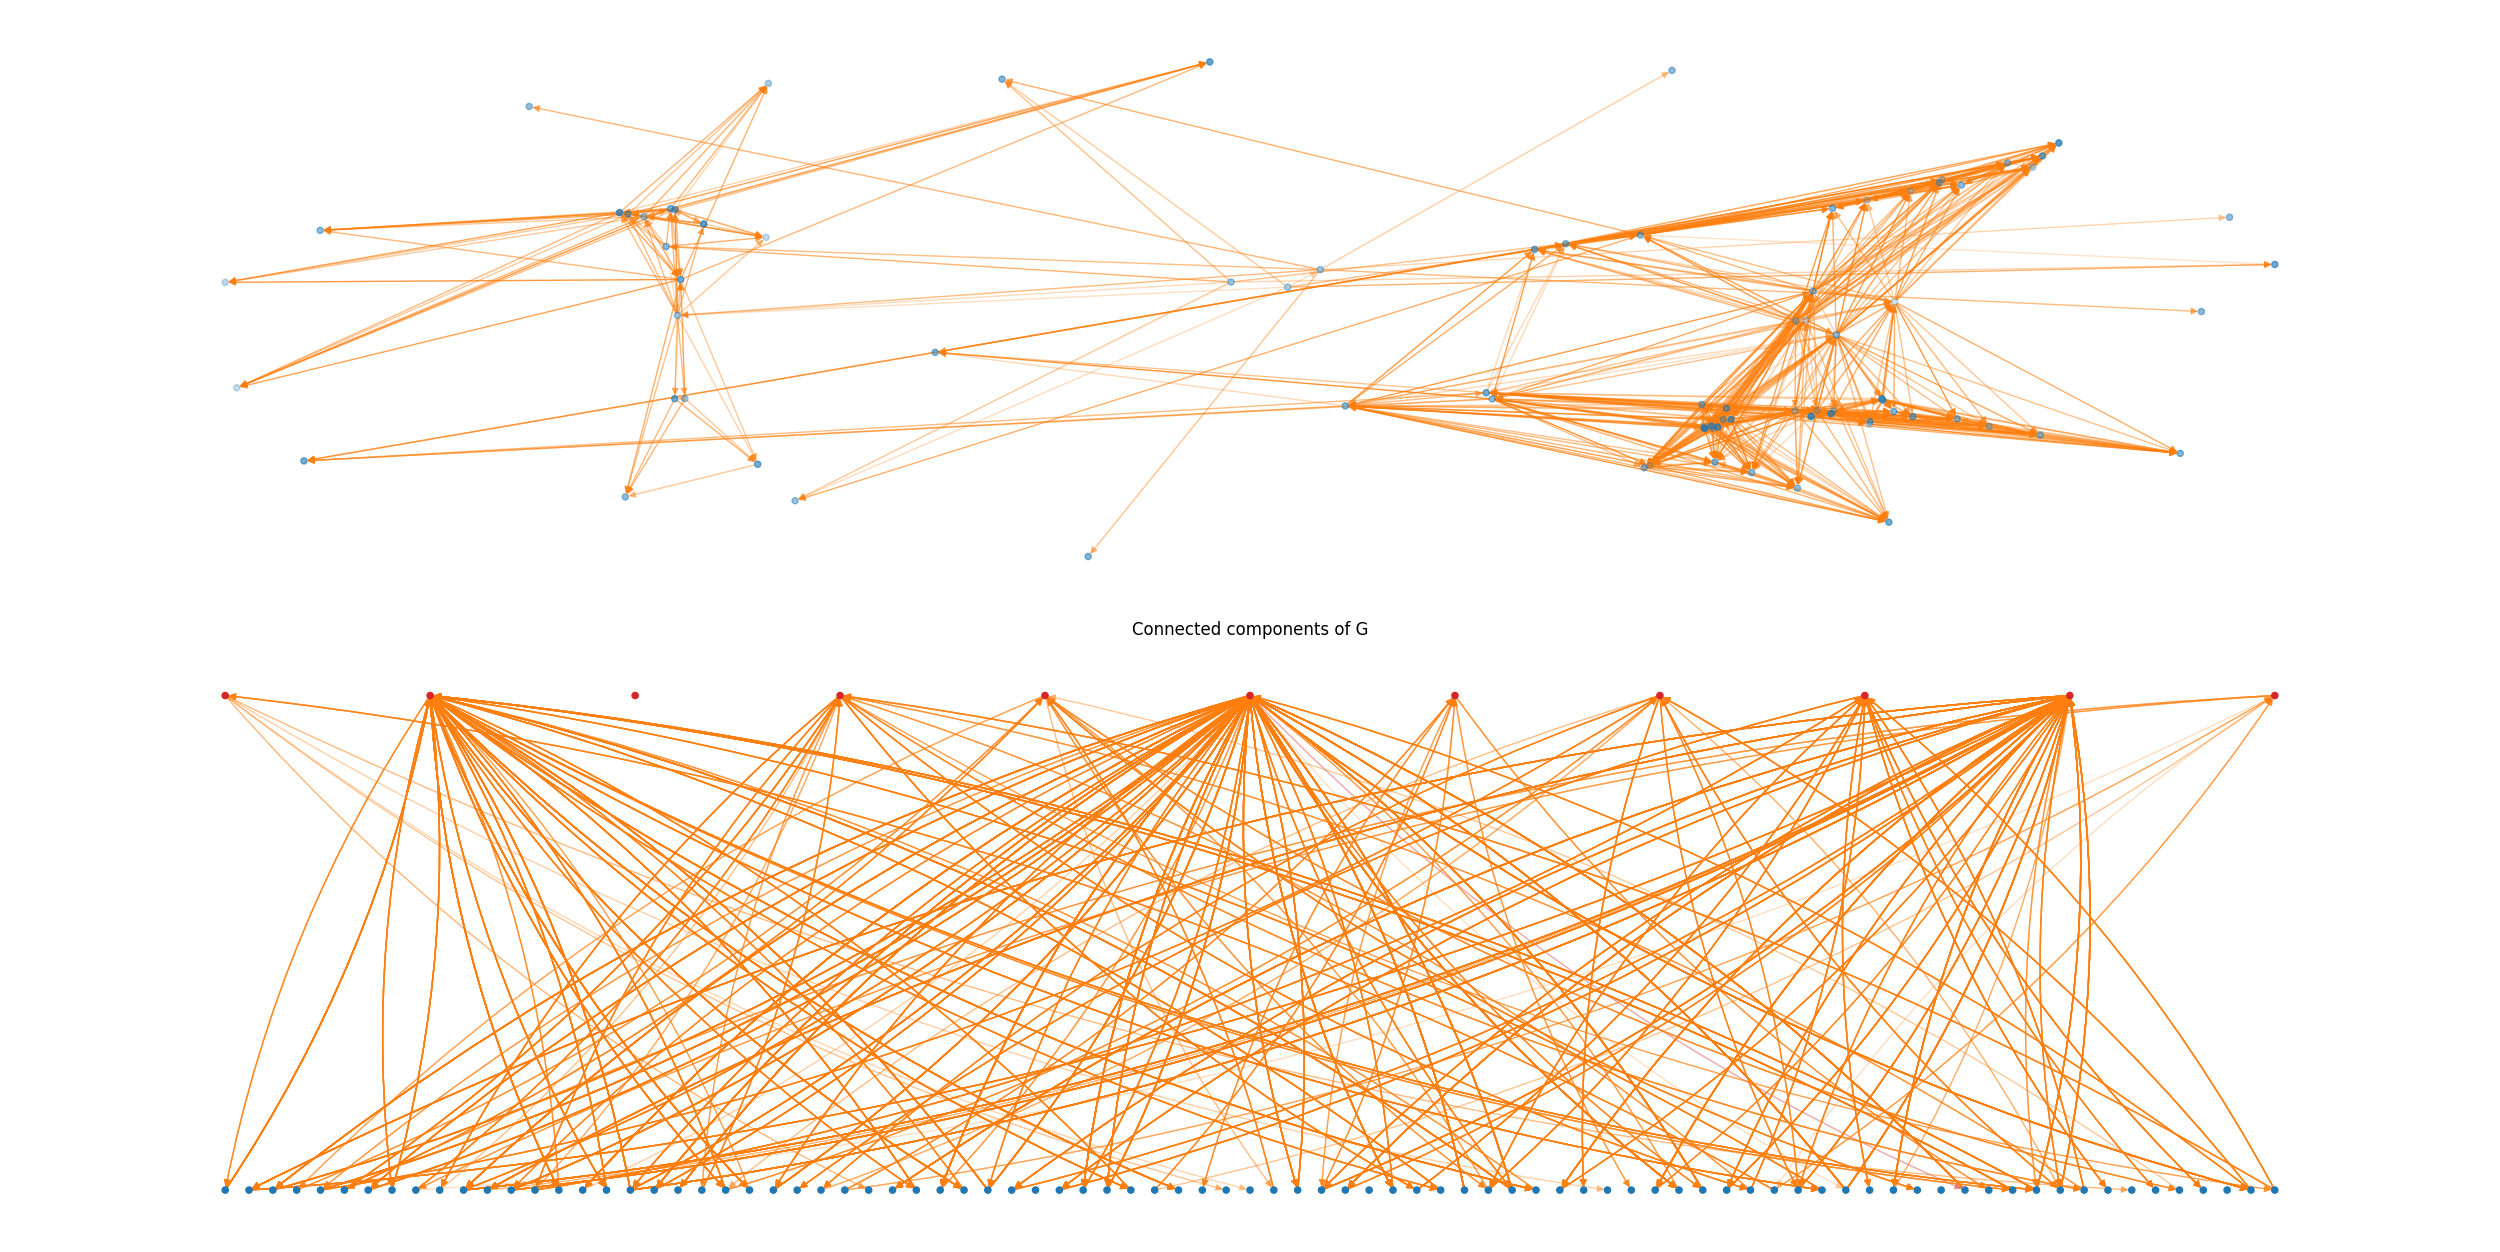

In [406]:
fig = plt.figure("Degree of a random graph", figsize=(32, 16))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(6, 12)

target_id = 10
targets = [gnn_explainer_results[idx][target_id][1] for idx in range(3)]
idx = 1

visualize_explanation(targets[idx], median_explanations[idx], df.iloc[idx]['mode'], 0, 4 * 3, fig, axgrid)

plt.show()

In [ ]:
loaded_model, train_samples, test_samples = get_model_and_samples(df.iloc[2])

EPOCHS = 10
pg_explainer = Explainer(
    model=loaded_model,
    algorithm=PGExplainer(epochs=EPOCHS, lr=0.003),
    explanation_type='phenomenon',
    edge_mask_type='object',
    model_config=dict(
        mode='regression',
        task_level='graph',
        return_type='raw',
    ),
)

# Train against a variety of node-level or graph-level predictions:
for epoch in tqdm(range(EPOCHS)):
    losses = []
    for index, sample in enumerate(train_samples):  # Indices to train against.
        # print(sample.y)
        loss = pg_explainer.algorithm.train(
            epoch, 
            loaded_model, 
            sample.x, 
            sample.edge_index, 
            target=sample.y[4],
            batch_index=sample.batch, 
            # index=4
        )
        losses.append(loss)
    print(f"{np.mean(losses)}")

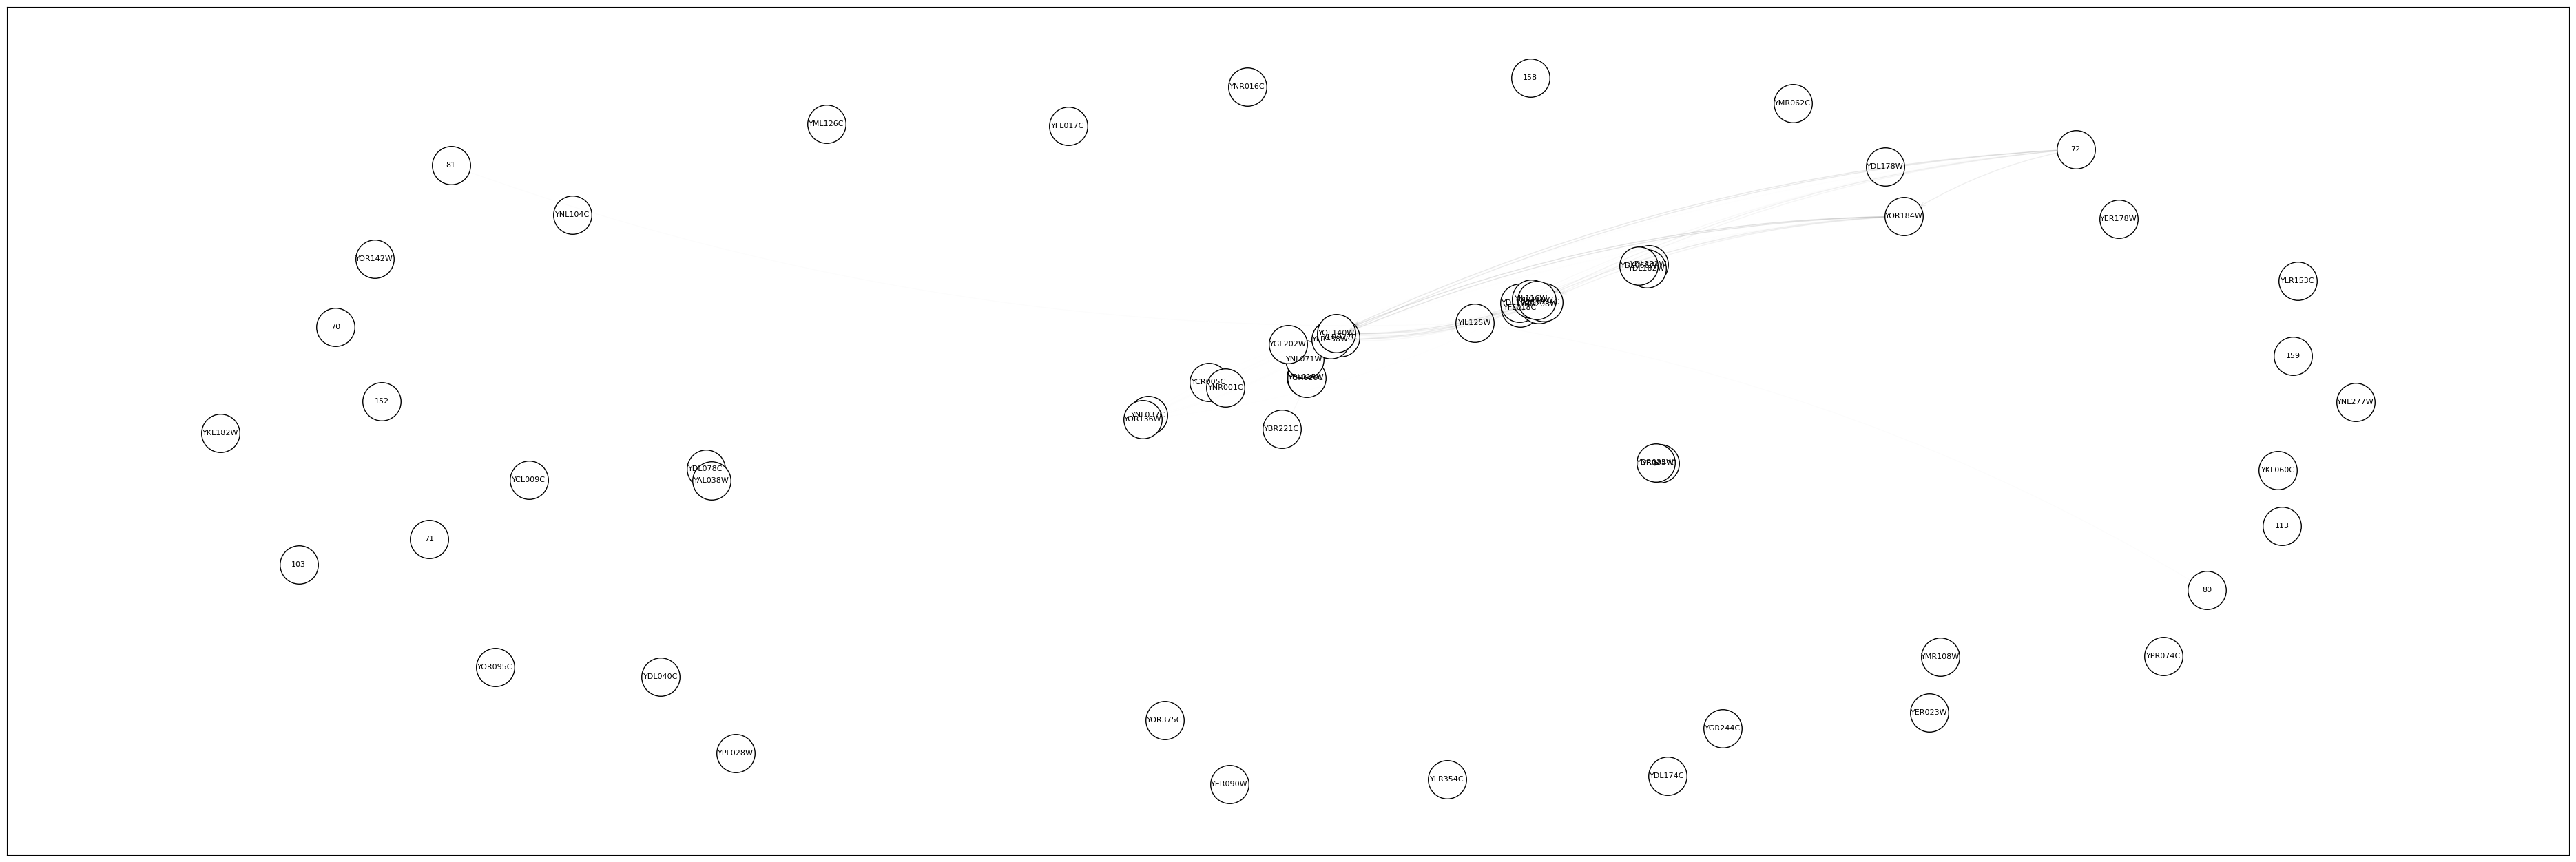

In [59]:
EXAMPLE = 10
data = test_samples[EXAMPLE]

# Get the final explanations:
explanation = pg_explainer(
    data.x, 
    data.edge_index, 
    target=data.y,
    batch_index=data.batch,
    index=4,
)

visualize_explanation(explanation)